### Hourly Power Curve Example
The notebook attempts to build an hourly granularity power curve from traded contract granularity peak and offpeak prices. The methodology here is simplified from reality for the following reasons:
* No clock changes or discounting is incorporated into the weighting function. This should be straight forward to rectify.
* Only monthly, quarterly and seasonal granarity contracts are included. The inclusion of higher granarity forward contracts at the start of the curve (e.g. hourly, daily, weekday, weekend) is a significant complicator in practice due to the bootstrapper and spline yielding non-desirable results (e.g. unrealstic curve shape).
* No gaps or redundancy. In practice gaps can be filled by either shaping in the boostrapper, or interpolated with the spline. The bootstrapper can handle redundancy by setting the allow_redundancy argument to True, but it is preferable to strip out all redundancy before trying to build the curve.
* All shaping factors (as have prices) have been arbitrarily guessed and not discussion is made on how these should be estimated from historical data or fundamentals.
* Doesn't use UK EFA calendar for contracts, so more suitable for European power.

In [1]:
from curves import bootstrap_contracts, max_smooth_interp, contract_period as cp, weighting, adjustments, tension_spline
from collections import namedtuple

PowerCurvePoint = namedtuple("PowerCurvePoint", "contract baseload_price peak_price")
use_tension_spline = True
tension = 0.5

curve_prices = [
    PowerCurvePoint(cp.jul(2022), 17.45, 29.55),
    PowerCurvePoint(cp.aug(2022), 16.23, 32.89),
    PowerCurvePoint(cp.q_3(2022), 17.41, 28.99),
    PowerCurvePoint(cp.q_4(2022), 21.07, 41.96),
    PowerCurvePoint(cp.q_1(2023), 22.84, 43.82),
    PowerCurvePoint(cp.summer(2023), 15.53, 28.65),
    PowerCurvePoint(cp.winter(2023), 20.98, 40.02)
]

def discount_factor(p):
    return 1.0

In [2]:
# For simplicity same shaping ratios used for peak and offpeak, probably they should be different
shaping_ratios = [
    # month to quarter shaping
    (cp.dec(2022), cp.q_4(2022), 1.19),
    (cp.nov(2022), cp.q_4(2022), 0.96),
    (cp.jan(2023), cp.q_1(2023), 1.25),
    (cp.feb(2023), cp.q_1(2023), 1.08),
    
    # month to month shaping
    # Q2-23
    (cp.apr(2023), cp.may(2023), 1.05),
    (cp.may(2023), cp.jun(2023), 1.02),
    # Q3-23
    (cp.jul(2023), cp.aug(2023), 1.02),
    (cp.aug(2023), cp.sep(2023), 0.94),
    # Q4-23
    (cp.dec(2023), cp.nov(2023), 1.12),
    (cp.nov(2023), cp.oct(2023), 1.02),
    # Q1-24
    (cp.jan(2024), cp.feb(2024), 1.08),
    (cp.feb(2024), cp.mar(2024), 1.03),
        
    # quarter to quarter shaping
    (cp.q_2(2023), cp.q_3(2023), 0.98),
    (cp.q_4(2023), cp.q_1(2024), 0.96)
]

peak_intra_week_shaping = adjustments.dayofweek(
    monday=0.97,
    tuesday=1.01,
    wednesday=1.03,
    thursday=1.00,
    friday=0.96,
    default=1.0
)

offpeak_intra_week_shaping = adjustments.dayofweek(
    default=1.0, # Assume no weekday shape for offpeak, might not be realistic
    saturday=0.85,
    sunday=0.81
)

# Shaping to 4-hour blocks, ratio of block price to daily price
weekend_block_ratios = {
    0 : 0.84,
    4 : 0.88,
    8 : 1.09,
    12 : 1.12,
    16 : 1.09,
    20 : 0.91
}

weekday_peak_block_ratios = {
    8 : 0.98,
    12 : 1.03,
    16 : 0.94
}

weekday_offpeak_block_ratios = {
    0 : 0.96,
    4 : 0.98,
    20 : 1.04
}

def normalise_to_1_average(block_ratios):
    sum_ratios=0.0
    for ratio in block_ratios.values():
        sum_ratios+=ratio
    avg_ratio = sum_ratios/len(block_ratios)
    return {key: value/avg_ratio for (key, value) in block_ratios.items()}

weekend_block_ratios = normalise_to_1_average(weekend_block_ratios)
weekday_peak_block_ratios = normalise_to_1_average(weekday_peak_block_ratios)
weekday_offpeak_block_ratios = normalise_to_1_average(weekday_offpeak_block_ratios)

<AxesSubplot:title={'center':'Bootstrapped and Shaped Peak Curve'}>

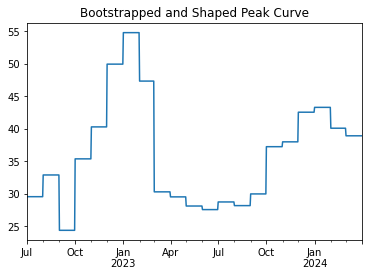

In [3]:
# Bootstrap and Shape Peak Prices to Monthly
raw_peak_curve_points = [(pcp.contract, pcp.peak_price) for pcp in curve_prices]

peak_weighting = weighting.num_weekdays()

monthly_peak_curve, bootstrapped_peak_contracts = \
    bootstrap_contracts(freq='M', contracts=raw_peak_curve_points, shaping_ratios=shaping_ratios, 
                       average_weight=peak_weighting)
piecewise_daily_peak_curve = monthly_peak_curve.resample('D').fillna('pad')

%matplotlib inline
piecewise_daily_peak_curve.plot(title='Bootstrapped and Shaped Peak Curve')


<AxesSubplot:title={'center':'Smoothed Versus Piecewise Daily Peak Curve'}>

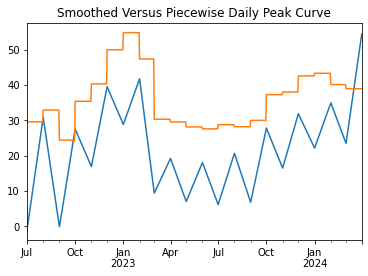

In [18]:
# Apply Spline to Calculate Daily Peak Price with Intra-week Shaping

if use_tension_spline:
    tension=0.000000001
    smooth_daily_peak_curve, _ = tension_spline(monthly_peak_curve, freq='D', tension=tension, 
                                    discount_factor=discount_factor) #, mult_season_adjust=peak_intra_week_shaping,
                                    # average_weight=peak_weighting)
else:
    smooth_daily_peak_curve = max_smooth_interp(monthly_peak_curve, freq='D', mult_season_adjust=peak_intra_week_shaping,
                                    average_weight=peak_weighting)
smooth_daily_peak_curve.plot(title='Smoothed Versus Piecewise Daily Peak Curve')
piecewise_daily_peak_curve.plot()

In [5]:
# Derive offpeak prices
import pandas as pd

def offpeak_weighting(period):
    wkend_mask = "Sat Sun"
    wkend_freq=pd.offsets.CustomBusinessDay(weekmask=wkend_mask)
    start_day = period.asfreq('D', 's').to_timestamp()
    end_day = period.asfreq('D', 'e').to_timestamp()
    num_wkend_days = len(pd.date_range(start=start_day, end=end_day, freq=wkend_freq))
    num_wk_days = len(pd.date_range(start=start_day, end=end_day, freq='B'))
    return num_wkend_days*2 + num_wk_days

offpeak_contracts = []
for curve_price in curve_prices:
    contract = curve_price.contract
    peak_weight = peak_weighting(contract)
    offpeak_weight = offpeak_weighting(contract)
    total_weight = peak_weight + offpeak_weight
    offpeak_price = (curve_price.baseload_price * total_weight - curve_price.peak_price * peak_weight)/offpeak_weight
    offpeak_contracts.append((contract, offpeak_price))


<AxesSubplot:title={'center':'Smoothed Versus Piecewise Daily Offpeak Curve'}>

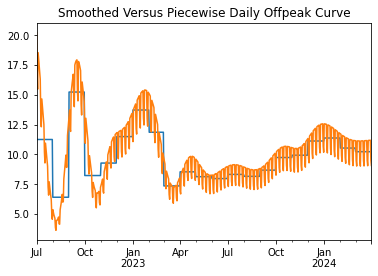

In [6]:
# Bootstrap and Shape Offpeak Prices to Monthly
monthly_offpeak_curve, bootstrapped_offpeak_contracts = \
    bootstrap_contracts(freq='M', contracts=offpeak_contracts, shaping_ratios=shaping_ratios, # TODO use different shaping ratios
                       average_weight=offpeak_weighting)
piecewise_daily_offpeak_curve = monthly_offpeak_curve.resample('D').fillna('pad')

# Apply Spline to Calculate Daily Offpeak Price with Intra-week Shaping

smooth_daily_offpeak_curve = max_smooth_interp(monthly_offpeak_curve, freq='D', mult_season_adjust=offpeak_intra_week_shaping,
                                    average_weight=offpeak_weighting)

%matplotlib inline
piecewise_daily_offpeak_curve.plot(title='Smoothed Versus Piecewise Daily Offpeak Curve')
smooth_daily_offpeak_curve.plot()

In [7]:
# Calculate 4-hour Block Prices From Shaping Ratios

def calc_shaped_block_prices(price, ratios):
    ret = []
    for block_start_hour in ratios.keys():
        shaped_block_price = price * ratios[block_start_hour]
        block_start = pd.Period(freq='H', year=day.year, month=day.month, day=day.day, hour=block_start_hour)
        block_end = pd.Period(freq='H', year=day.year, month=day.month, day=day.day, hour=block_start_hour+3)
        block_contract = ((block_start, block_end), shaped_block_price)
        ret.append(block_contract)
    return ret
        

block_contracts = []
for day in smooth_daily_peak_curve.index:
    if day.dayofweek < 5: # Weekday
        peak_price = smooth_daily_peak_curve[day]
        weekday_peak_blocks = calc_shaped_block_prices(peak_price, weekday_peak_block_ratios)
        block_contracts.extend(weekday_peak_blocks)
        
        offpeak_price = smooth_daily_offpeak_curve[day]
        weekday_offpeak_blocks = calc_shaped_block_prices(offpeak_price, weekday_offpeak_block_ratios)
        block_contracts.extend(weekday_offpeak_blocks)
    else: # Weekend
        offpeak_price = smooth_daily_offpeak_curve[day]
        wkend_blocks = calc_shaped_block_prices(offpeak_price, weekend_block_ratios)
        block_contracts.extend(wkend_blocks)

block_contracts.sort(key=lambda ctrct: ctrct[0][0]) # Sort by start
len(block_contracts)

3840

In [8]:
# Interpolate to Hourly From Shaped 4-hour Blocks
smooth_hourly_curve = max_smooth_interp(block_contracts, freq='H')

OutOfMemoryException: Array dimensions exceeded supported range.
   at MathNet.Numerics.LinearAlgebra.MatrixBuilder`1.Dense(Int32 rows, Int32 columns)
   at Cmdty.Curves.MaxSmoothnessSplineCurveBuilder`1.Build(List`1 contracts, Func`2 weighting, Func`2 multAdjustFunc, Func`2 addAdjustFunc, Func`3 timeFunc, Nullable`1 frontFirstDerivative, Nullable`1 backFirstDerivative)
   at Cmdty.Curves.MaxSmoothnessSplineCurveBuilder`1.BuildCurve()